### Variational autoencoder to classify Strawberry shapes

The code can also generate new strawberry samples

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.python.keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

from tensorflow.python.framework import ops
ops.reset_default_graph()
K.clear_session()
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import cv2
np.random.seed(237)

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.3.1


In [4]:
X=np.load("X_data.npy")
Y=np.load("Y_data.npy")
Classes=np.load("Labels.npy")

In [5]:
import tensorboard
tensorboard.__version__

'2.3.0'

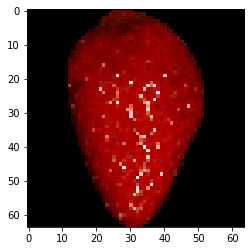

In [6]:
plt.imshow(X[22,:,:,:])

In [9]:

# Clear any logs from previous runs
!rm -rf ./logs/

In [10]:
X_gray=[]
for i in range(0,X.shape[0]):
    gray = cv2.cvtColor(X[i,:,:,:], cv2.COLOR_RGB2GRAY)
    X_gray.append(gray)

In [11]:
X_gray=np.array(X_gray)

In [12]:
X_gray.shape

(1920, 64, 64)

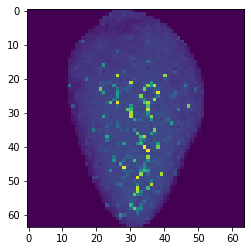

In [13]:
plt.imshow(X_gray[22,:,:])

In [14]:
trainX=X_gray.reshape(X_gray.shape[0],X_gray.shape[1]*X_gray.shape[2])


In [15]:
train_orig=pd.DataFrame(trainX)


In [16]:
valid = train_orig.sample(n = 190, random_state = 555)
train = train_orig.loc[~train_orig.index.isin(valid.index)]

Classval=Classes[train_orig.sample(n = 190, random_state = 555).index]
Classtrain = np.delete(Classes, train_orig.sample(n = 190, random_state = 555).index)
#valid.head()

In [17]:
Classtrain.shape
#we have 1730 images 

(1730,)

In [18]:
# X's
X_train = train
X_valid = valid


X_train = X_train.values.reshape(-1,64,64,1)

X_valid = X_valid.values.reshape(-1,64,64,1)

In [19]:
X_train.shape

(1730, 64, 64, 1)

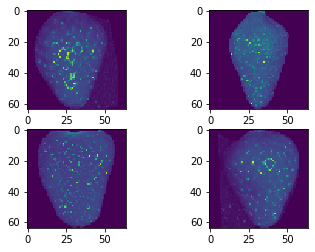

In [20]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[691][:,:,0])

plt.subplot(223)
plt.imshow(X_train[1000][:,:,0])

plt.subplot(224)
plt.imshow(X_train[343][:,:,0])
plt.show()

In [38]:
X_train.shape ## images stored at array 

(1730, 64, 64, 1)

In [21]:
img_shape = (64, 64, 1)    # for straw
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters
class_shape=(1720,)
# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

cond = keras.Input(shape=class_shape)
x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [22]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    #create a tensor of error, equal shape than latent_dim 
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [23]:
# The decoder network (To revert the encoder step)

In [24]:
#decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

###  D. Loss
We need one more thing and that's something that will calculate the unique loss function the VAE requires. Recall that the VAE is trained using a loss function with two components:

1-'Reconstruction loss' - This is the cross-entropy describing the errors between the decoded samples from the latent distribution and the original inputs.

2-The Kullback-Liebler divergence between the latent distribution and the prior (this acts as a sort of regularization term).

We define a custom layer class that calculates the loss.

In [25]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

# Model summary

In [26]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
#,experimental_run_tf_function=False
vae.summary()

W1104 20:40:15.098541 139638948243264 training_utils.py:1500] Output custom_variational_layer missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   36928       conv2d_1[0][0]                   
_______________________________________________________________________________________

In [27]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


## Training the model

In [28]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=200,
        batch_size=batch_size,
        validation_data=(X_valid, None),callbacks=[tensorboard_callback])

Train on 1730 samples, validate on 190 samples
Epoch 1/200
  32/1730 [..............................] - ETA: 22s - loss: 0.6904

W1104 20:40:32.881567 139638948243264 callbacks.py:323] Callbacks method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0241s vs `on_train_batch_begin` time: 0.3180s). Check your callbacks.
W1104 20:40:32.882743 139638948243264 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0241s vs `on_train_batch_end` time: 0.0796s). Check your callbacks.


1730/1730 [==============================] - ETA: 0s - loss: 0.3760

W1104 20:40:34.401558 139638948243264 deprecation.py:323] From /usr/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


1730/1730 [==============================] - 2s 1ms/sample - loss: 0.3760 - val_loss: 0.2883
Epoch 2/200
1730/1730 [==============================] - 2s 887us/sample - loss: 0.2745 - val_loss: 0.2848
Epoch 3/200
1730/1730 [==============================] - 2s 903us/sample - loss: 0.2723 - val_loss: 0.2880
Epoch 4/200
1730/1730 [==============================] - 2s 906us/sample - loss: 0.2702 - val_loss: 0.2816
Epoch 5/200
1730/1730 [==============================] - 2s 896us/sample - loss: 0.2696 - val_loss: 0.2804
Epoch 6/200
1730/1730 [==============================] - 2s 885us/sample - loss: 0.2691 - val_loss: 0.2789
Epoch 7/200
1730/1730 [==============================] - 2s 880us/sample - loss: 0.2686 - val_loss: 0.2848
Epoch 8/200
1730/1730 [==============================] - 2s 876us/sample - loss: 0.2685 - val_loss: 0.2816
Epoch 9/200
1730/1730 [==============================] - 2s 887us/sample - loss: 0.2681 - val_loss: 0.2811
Epoch 10/200
1730/1730 [===========================

1730/1730 [==============================] - 2s 883us/sample - loss: 0.2663 - val_loss: 0.2781
Epoch 78/200
1730/1730 [==============================] - 2s 911us/sample - loss: 0.2662 - val_loss: 0.2775
Epoch 79/200
1730/1730 [==============================] - 2s 912us/sample - loss: 0.2662 - val_loss: 0.2775
Epoch 80/200
1730/1730 [==============================] - 2s 916us/sample - loss: 0.2662 - val_loss: 0.2776
Epoch 81/200
1730/1730 [==============================] - 2s 916us/sample - loss: 0.2662 - val_loss: 0.2776
Epoch 82/200
1730/1730 [==============================] - 2s 913us/sample - loss: 0.2662 - val_loss: 0.2780
Epoch 83/200
1730/1730 [==============================] - 2s 924us/sample - loss: 0.2662 - val_loss: 0.2772
Epoch 84/200
1730/1730 [==============================] - 2s 918us/sample - loss: 0.2662 - val_loss: 0.2777
Epoch 85/200
1730/1730 [==============================] - 2s 915us/sample - loss: 0.2662 - val_loss: 0.2790
Epoch 86/200
1730/1730 [=================

### A. Clustering of strawberries in the latent space
We can make predictions on the validation set using the encoder network. This has the effect of translating the images from the 784-dimensional input space into the 2-dimensional latent space. When we color-code those translated data points according to their known digit class, we can see how the digits cluster together.

In [42]:
# Isolate original training set records in validation set
valid_noTest = pd.DataFrame(trainX)



In [43]:
# X's and Y's
X_valid_noTest = valid_noTest
#y_valid_noTest = testY

# Reshape and normalize
#X_valid_noTest = X_valid_noTest.astype('float32') / 255.
X_valid_noTest = X_valid_noTest.values.reshape(-1,64,64,1)

In [44]:
X_valid_noTest.shape

(1920, 64, 64, 1)

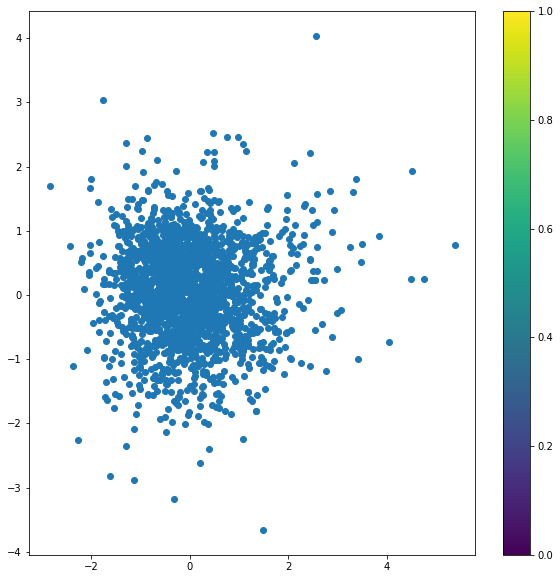

In [45]:
#Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_valid_noTest,batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1],  cmap='brg')
plt.colorbar()
plt.show()

In [46]:
x_valid_noTest_encoded.shape

(1920, 2)

In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [48]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x_valid_noTest_encoded)
    Sum_of_squared_distances.append(km.inertia_)

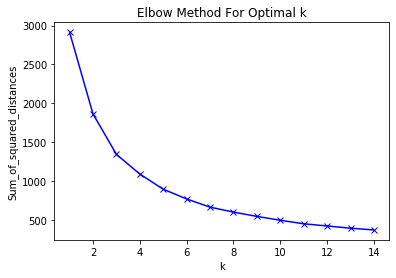

In [49]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [50]:
# 4 or 5 is the optimal number 
km = KMeans(n_clusters=2)
km = km.fit(x_valid_noTest_encoded)

In [51]:
km.labels_

array([1, 0, 1, ..., 1, 0, 1], dtype=int32)

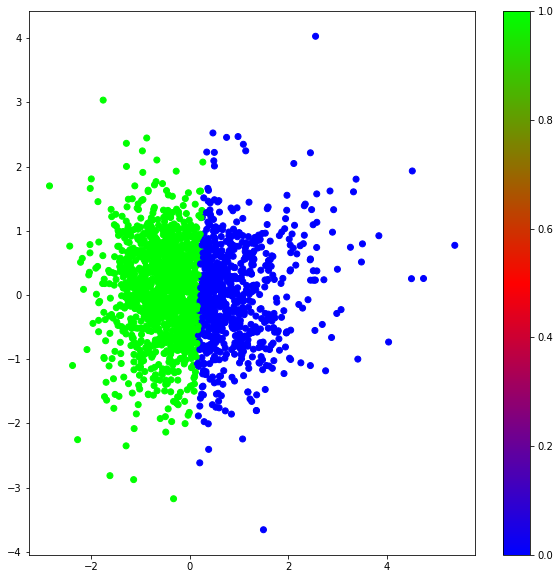

In [52]:
#Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_valid_noTest,batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=km.labels_, cmap='brg')
plt.colorbar()
plt.show()

In [53]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


For n_clusters = 2 The average silhouette_score is : 0.35103288
For n_clusters = 3 The average silhouette_score is : 0.3317024
For n_clusters = 4 The average silhouette_score is : 0.31316784
For n_clusters = 5 The average silhouette_score is : 0.32137394
For n_clusters = 6 The average silhouette_score is : 0.31459638
For n_clusters = 7 The average silhouette_score is : 0.3269501
For n_clusters = 8 The average silhouette_score is : 0.3185119
For n_clusters = 9 The average silhouette_score is : 0.3174568


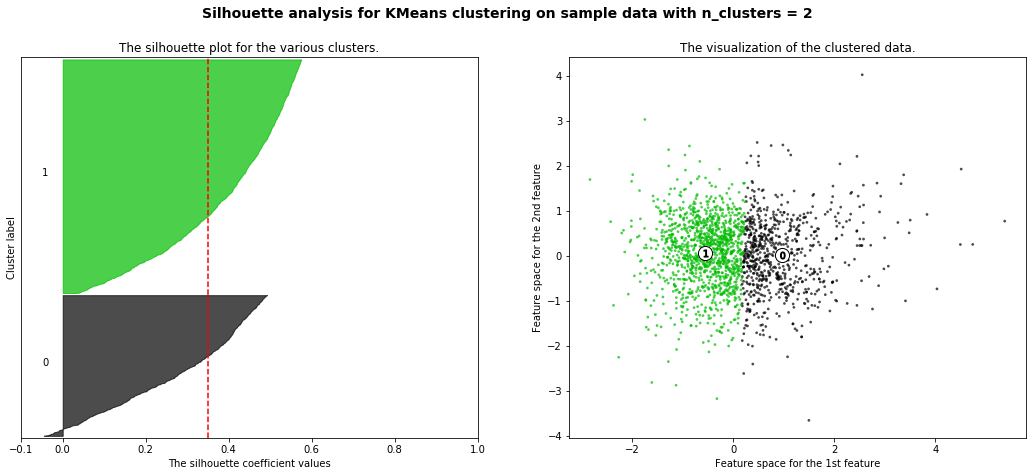

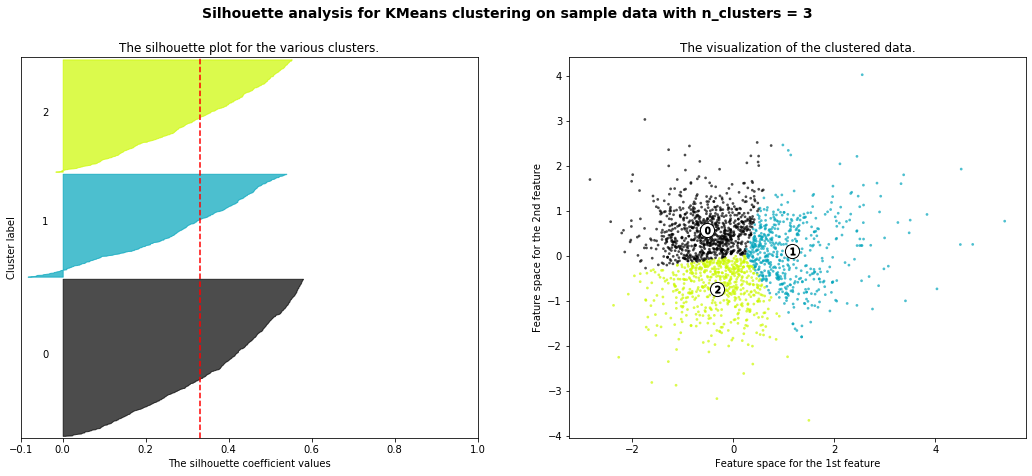

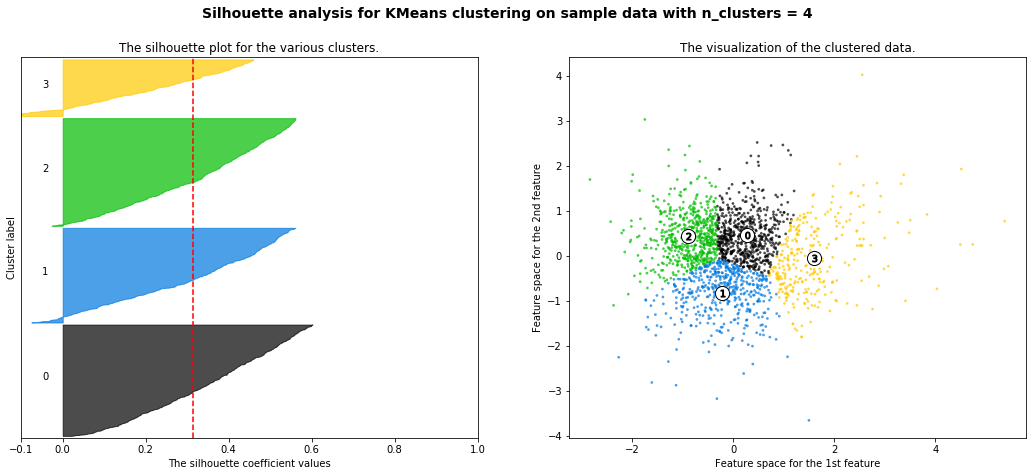

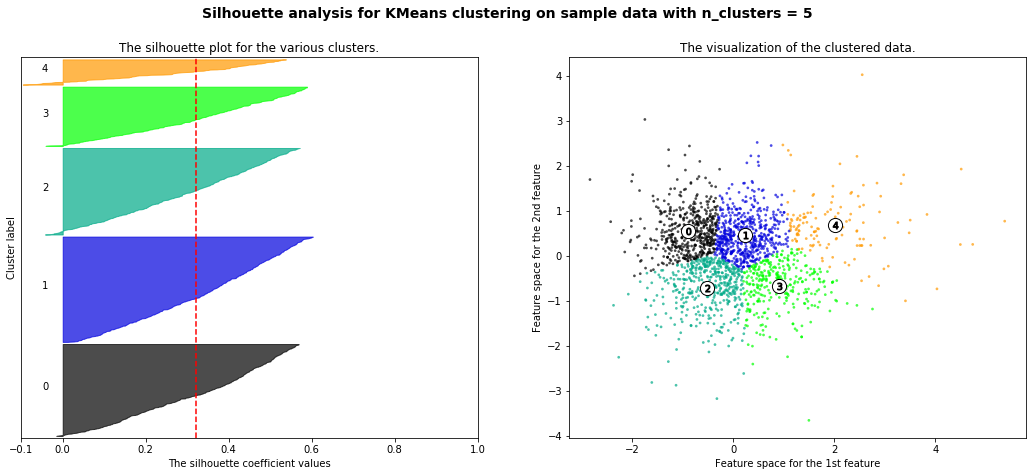

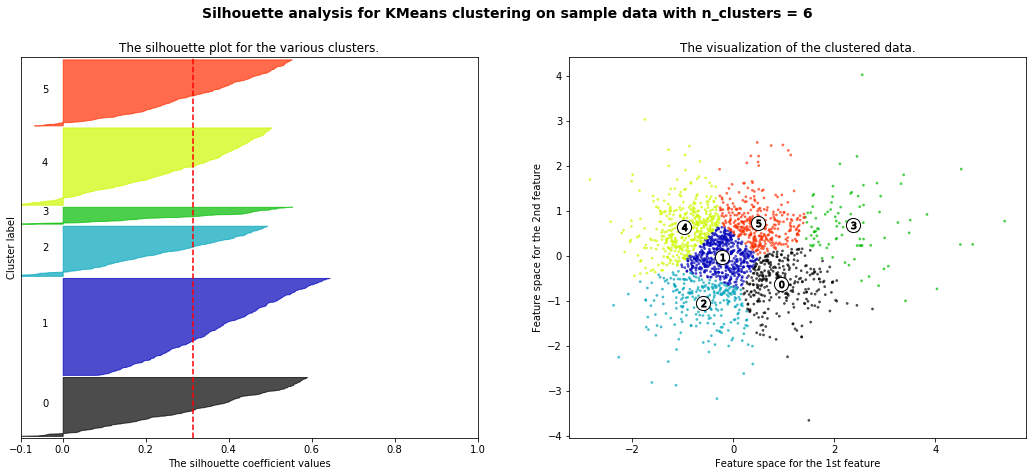

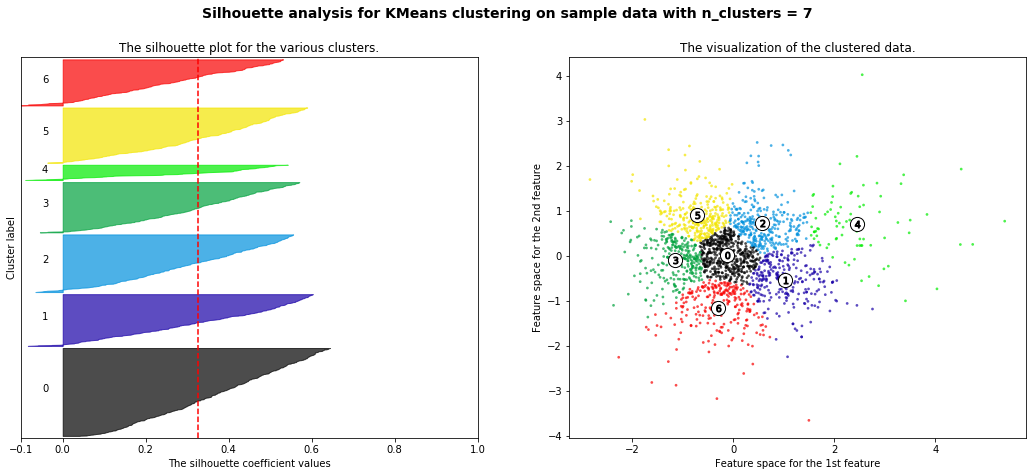

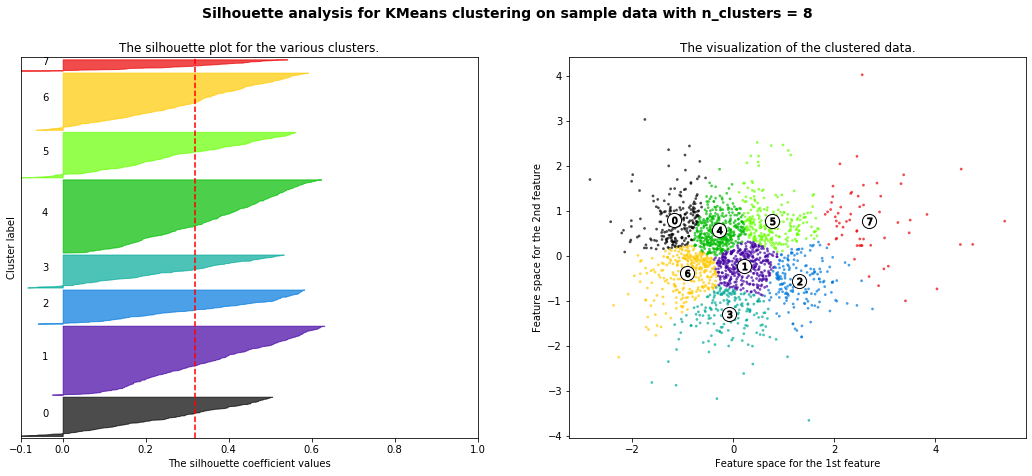

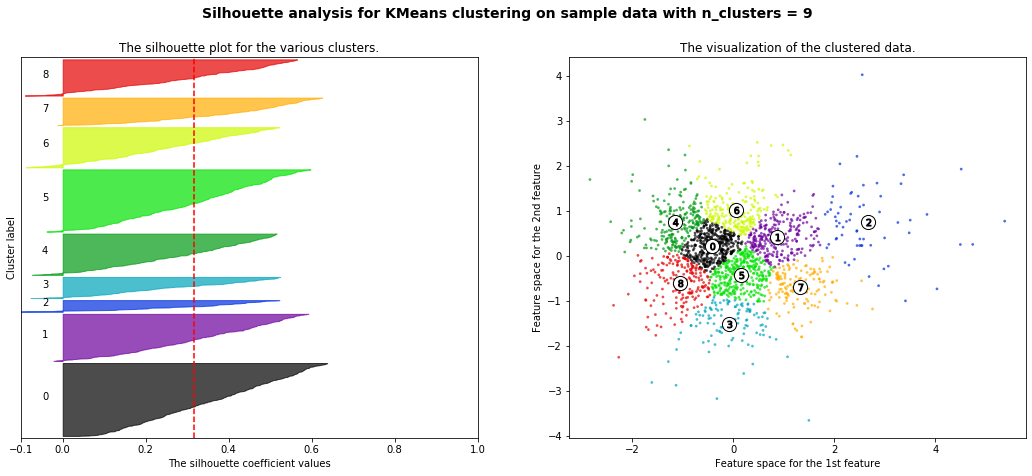

In [54]:
range_n_clusters = [2, 3, 4, 5, 6,7,8,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_valid_noTest_encoded) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_valid_noTest_encoded)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_valid_noTest_encoded, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_valid_noTest_encoded, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #print(colors)
    ax2.scatter(x_valid_noTest_encoded[:, 0],x_valid_noTest_encoded[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [55]:
clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels = clusterer.fit_predict(x_valid_noTest_encoded)
cluster_labels

array([1, 0, 1, ..., 1, 0, 1], dtype=int32)

For n_clusters = 2 The average silhouette_score is : 0.35103288


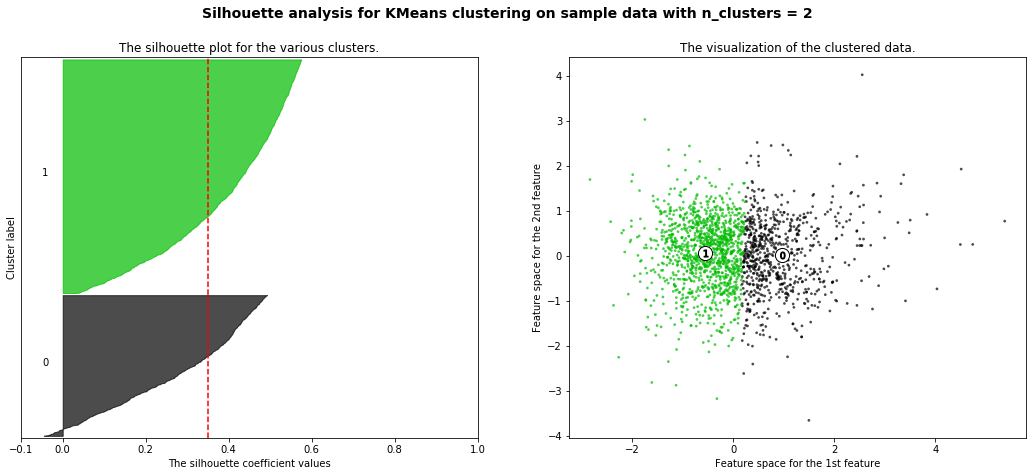

In [56]:
range_n_clusters = [2]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_valid_noTest_encoded) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_valid_noTest_encoded)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_valid_noTest_encoded, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_valid_noTest_encoded, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #print(colors)
    ax2.scatter(x_valid_noTest_encoded[:, 0],x_valid_noTest_encoded[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [57]:
selection=[]
for i in range(0,2):
    selection.append(np.random.choice(np.asarray(np.where(cluster_labels==i))[0,:],4))   

   

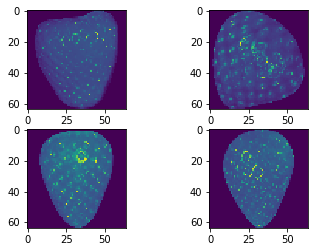

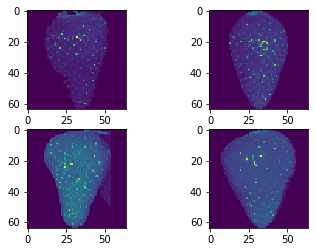

In [58]:
for i in selection: 
    
    plt.figure(1)
    plt.subplot(221)
    plt.imshow(X_gray[i[0]])

    plt.subplot(222)
    plt.imshow(X_gray[i[1]])

    plt.subplot(223)
    plt.imshow(X_gray[i[2]])

    plt.subplot(224)
    plt.imshow(X_gray[i[3]])
    plt.show()

In [49]:
np.save('Labels.npy', cluster_labels)

# Generating new strawberry images from noise 

In [59]:
Z_DIM=(64,64,1)

In [60]:
M=np.random.normal(0,1,size=(10,64,64,1)).shape

In [61]:
x1=X_gray[1].reshape(1,64,64)

In [63]:
x1=X_gray.reshape(1920,64,64,1)

In [64]:
encoder = Model(input_img, z_mu)
encoded = encoder.predict(x1,batch_size=batch_size)


In [65]:
Out=decoder.predict(encoded)

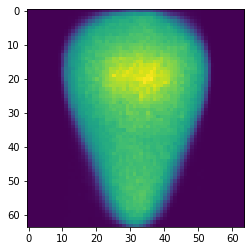

In [66]:
M=Out[165].reshape(64,64)
plt.imshow(M*255)

In [70]:
np.random.seed(2)
A=np.random.normal(0,1,size=(13,64,64,1))
A.shape
encoder = Model(input_img, z_mu)
encoded = encoder.predict(A,batch_size=batch_size)


In [71]:
encoded

array([[ 8.359124 ,  5.8811183],
       [ 9.056774 ,  4.566066 ],
       [13.629817 ,  5.4330006],
       [ 8.516738 ,  3.2911644],
       [ 7.338158 ,  2.3727338],
       [ 6.05315  ,  5.5286827],
       [ 6.50056  ,  5.4361486],
       [ 9.658144 ,  3.0292153],
       [ 8.443948 ,  3.0675318],
       [10.201593 ,  7.0324125],
       [ 6.6137676,  1.3834791],
       [ 9.429883 ,  6.8410068],
       [ 7.6803613,  7.397883 ]], dtype=float32)

In [72]:
Out=decoder.predict(encoded)

In [73]:
Out[0].shape

(64, 64, 1)

(array([2250.,  472.,  331.,  245.,  206.,  143.,  140.,   96.,   90.,
         123.]),
 array([6.6407158e-21, 9.9969946e-02, 1.9993989e-01, 2.9990983e-01,
        3.9987978e-01, 4.9984974e-01, 5.9981966e-01, 6.9978964e-01,
        7.9975957e-01, 8.9972955e-01, 9.9969947e-01], dtype=float32),
 <a list of 10 Patch objects>)

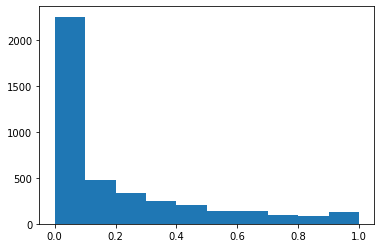

In [74]:
plt.hist(np.reshape(Out[0],64*64*1))

In [77]:
A=np.random.normal(0,1,size=(1,64,64,1))
encoder = Model(input_img, z_mu)
reconstruct_imgages = encoder.predict(A,batch_size=batch_size)
reconstruct_imgages

array([[10.785892 ,  2.6245792]], dtype=float32)

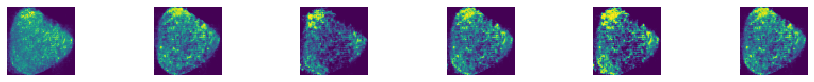

In [78]:

vae_generate_images(n_to_show=1) 